### 0. 前置操作

**导入`openDigger`包**

In [1]:
var openDigger = require('../src/open_digger');

**查看数据库**

In [2]:
var query = openDigger.driver.clickhouse.query;
query(
    `SHOW DATABASES`
).then(res=>{
    console.log(res);
})

[
  { name: '_temporary_and_external_tables' },
  { name: 'default' },
  { name: 'github_log' },
  { name: 'system' }
]


**查看`github_log`下的所有表**

In [3]:
query(
    `SHOW TABLES from github_log`
).then(res=>{
    console.log(res);
})

[
  { name: 'year2015' },
  { name: 'year2016' },
  { name: 'year2017' },
  { name: 'year2018' },
  { name: 'year2019' },
  { name: 'year2020' },
  { name: 'year2021' },
  { name: 'year2022' }
]


数据表字段可以在`docs/assets/data_description.csv`进行查看，或者在[https://github.com/X-lab2017/open-digger/blob/master/docs/assets/data_description.csv](https://github.com/X-lab2017/open-digger/blob/master/docs/assets/data_description.csv) 上进行查看

数据表中字段`type`的类型参考[https://docs.github.com/en/developers/webhooks-and-events/events/github-event-types](https://docs.github.com/en/developers/webhooks-and-events/events/github-event-types)

In [4]:
// 起始和终止年份和日期
var startYear = 2015, endYear = 2019;
var years = Array.from( {length: endYear - startYear + 1}, (_, i) => i + startYear);
var startMonth = 1, endMonth = 12;
var months = Array.from( {length: endMonth - startMonth + 1}, (_, i) => i + startMonth);
// 构建 Y-M 数组
var yms = Array()
for(let i = 0; i < years.length; i++) {
    for (let j = 0; j < months.length; j++) {
        yms.push({'y': years[i], 'm': months[j]});
    }
}
// 图标横坐标
yms_axis = yms.map(ym => ym['y'].toString() + '-' + ym['m'].toString())

[
  '2015-1',  '2015-2',  '2015-3',  '2015-4',  '2015-5',
  '2015-6',  '2015-7',  '2015-8',  '2015-9',  '2015-10',
  '2015-11', '2015-12', '2016-1',  '2016-2',  '2016-3',
  '2016-4',  '2016-5',  '2016-6',  '2016-7',  '2016-8',
  '2016-9',  '2016-10', '2016-11', '2016-12', '2017-1',
  '2017-2',  '2017-3',  '2017-4',  '2017-5',  '2017-6',
  '2017-7',  '2017-8',  '2017-9',  '2017-10', '2017-11',
  '2017-12', '2018-1',  '2018-2',  '2018-3',  '2018-4',
  '2018-5',  '2018-6',  '2018-7',  '2018-8',  '2018-9',
  '2018-10', '2018-11', '2018-12', '2019-1',  '2019-2',
  '2019-3',  '2019-4',  '2019-5',  '2019-6',  '2019-7',
  '2019-8',  '2019-9',  '2019-10', '2019-11', '2019-12'
]

### 1. 每月新增 Star 和 Frok 的个数

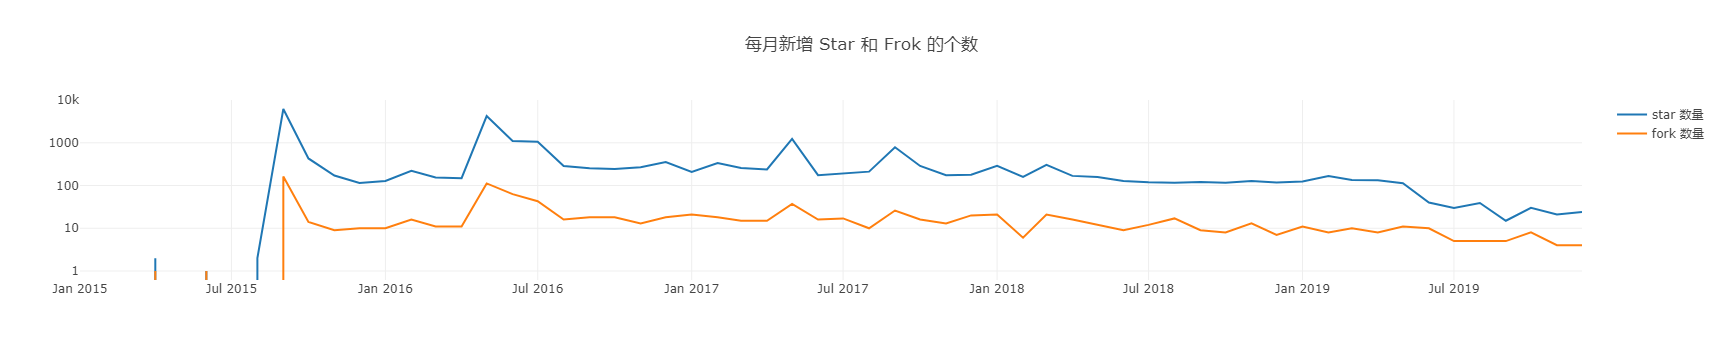

┌─────────┬───────────┬───────────┬───────────┐
│ (index) │   日期    │ star 数量 │ fork 数量 │
├─────────┼───────────┼───────────┼───────────┤
│    0    │ '2015-1'  │    '0'    │    '0'    │
│    1    │ '2015-2'  │    '0'    │    '0'    │
│    2    │ '2015-3'  │    '0'    │    '0'    │
│    3    │ '2015-4'  │    '2'    │    '1'    │
│    4    │ '2015-5'  │    '0'    │    '0'    │
│    5    │ '2015-6'  │    '1'    │    '1'    │
│    6    │ '2015-7'  │    '0'    │    '0'    │
│    7    │ '2015-8'  │    '2'    │    '0'    │
│    8    │ '2015-9'  │  '6167'   │   '162'   │
│    9    │ '2015-10' │   '430'   │   '14'    │
│   10    │ '2015-11' │   '171'   │    '9'    │
│   11    │ '2015-12' │   '114'   │   '10'    │
│   12    │ '2016-1'  │   '128'   │   '10'    │
│   13    │ '2016-2'  │   '222'   │   '16'    │
│   14    │ '2016-3'  │   '154'   │   '11'    │
│   15    │ '2016-4'  │   '148'   │   '11'    │
│   16    │ '2016-5'  │  '4225'   │   '112'   │
│   17    │ '2016-6'  │  '1100'   │   '63'    

In [8]:
Promise.all(yms.map(ym => {
    var q = `
            SELECT count(CASE WHEN repo_id='32665718' AND type='WatchEvent' AND toMonth(created_at)=${ym['m']} THEN 1 ELSE NULL END) AS star,
            count(CASE WHEN repo_id='32665718' AND type='ForkEvent' AND toMonth(created_at)=${ym['m']} THEN 1 ELSE NULL END) AS fork
            FROM github_log.year${ym['y']}
            `
    return query(q);
})).then(data => {
    var starCount = [], tableDict = [], forkCount = [];
    data.forEach((d, i) => {
        starCount.push(d[0].star);
        forkCount.push(d[0].fork);
        tableDict.push({'ym': yms_axis[i], 'star': starCount[starCount.length-1], 'fork': forkCount[forkCount.length-1]});
    });
    openDigger.render.plotly([
        {x: yms_axis, y: starCount, mode: 'scatter', name: 'star 数量'},
        {x: yms_axis, y: forkCount, mode: 'scatter', name: 'fork 数量'},
    ], {
        title: '每月新增 Star 和 Frok 的个数',
        yaxis: {type: 'log'}
    });
    console.table(tableDict.map((d) => {
        return {
            '日期': d.ym,
            'star 数量': d.star,
            'fork 数量': d.fork,
        };
    }));
})

### 2. 每月打开 Issue 和 关闭 Issue 的个数

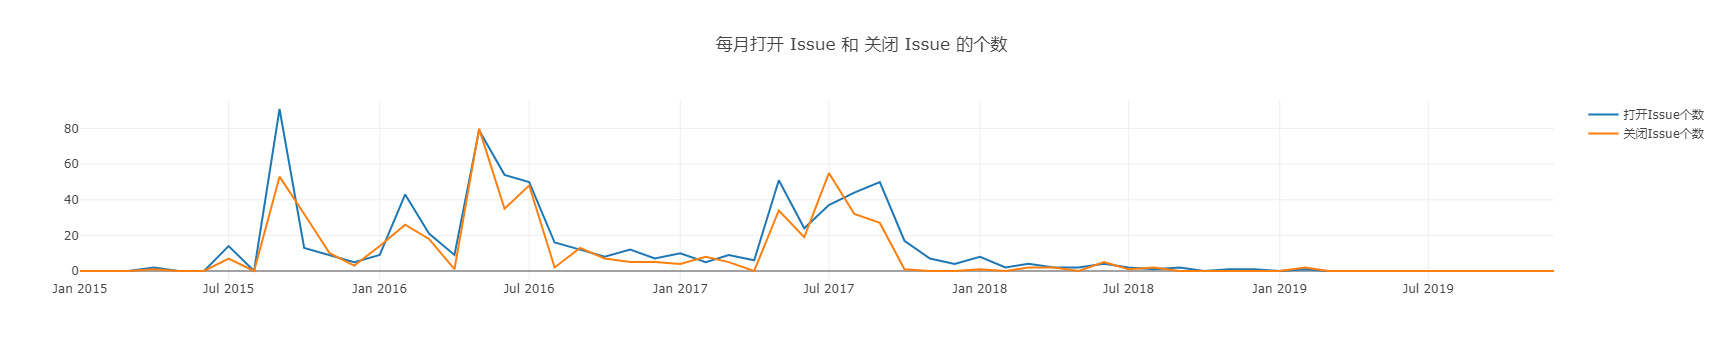

┌─────────┬───────────┬───────────────┬───────────────┐
│ (index) │   日期    │ 打开Issue个数 │ 关闭Issue个数 │
├─────────┼───────────┼───────────────┼───────────────┤
│    0    │ '2015-1'  │      '0'      │      '0'      │
│    1    │ '2015-2'  │      '0'      │      '0'      │
│    2    │ '2015-3'  │      '0'      │      '0'      │
│    3    │ '2015-4'  │      '2'      │      '1'      │
│    4    │ '2015-5'  │      '0'      │      '0'      │
│    5    │ '2015-6'  │      '0'      │      '0'      │
│    6    │ '2015-7'  │     '14'      │      '7'      │
│    7    │ '2015-8'  │      '0'      │      '0'      │
│    8    │ '2015-9'  │     '91'      │     '53'      │
│    9    │ '2015-10' │     '13'      │     '32'      │
│   10    │ '2015-11' │      '9'      │     '10'      │
│   11    │ '2015-12' │      '5'      │      '3'      │
│   12    │ '2016-1'  │      '9'      │     '14'      │
│   13    │ '2016-2'  │     '43'      │     '26'      │
│   14    │ '2016-3'  │     '21'      │     '18'      │
│ 

In [6]:
Promise.all(yms.map(ym => {
    var q = `
            SELECT count(CASE WHEN repo_id='32665718' AND type='IssuesEvent' AND action='opened' AND toMonth(created_at)=${ym['m']} THEN 1 ELSE NULL END) AS open,
            count(CASE WHEN repo_id='32665718' AND type='IssuesEvent' AND action='closed' AND toMonth(created_at)=${ym['m']} THEN 1 ELSE NULL END) AS close
            FROM github_log.year${ym['y']}
            `
    return query(q);
})).then(data => {
    var openCount = [], tableDict = [], closeCount = [];
    data.forEach((d, i) => {
        openCount.push(d[0].open);
        closeCount.push(d[0].close);
        tableDict.push({'ym': yms_axis[i], 'open': openCount[openCount.length-1], 'close': closeCount[closeCount.length-1]});
    });
    openDigger.render.plotly([
        {x: yms_axis, y: openCount, mode: 'scatter', name: '打开Issue个数'},
        {x: yms_axis, y: closeCount, mode: 'scatter', name: '关闭Issue个数'},
    ], {
        title: '每月打开 Issue 和 关闭 Issue 的个数',
    });
    console.table(tableDict.map((d) => {
        return {
            '日期': d.ym,
            '打开Issue个数': d.open,
            '关闭Issue个数': d.close,
        };
    }));
})

### 3. 每月打开 PR 和合入 PR 的个数（注意，关闭 PR 不等于合入）

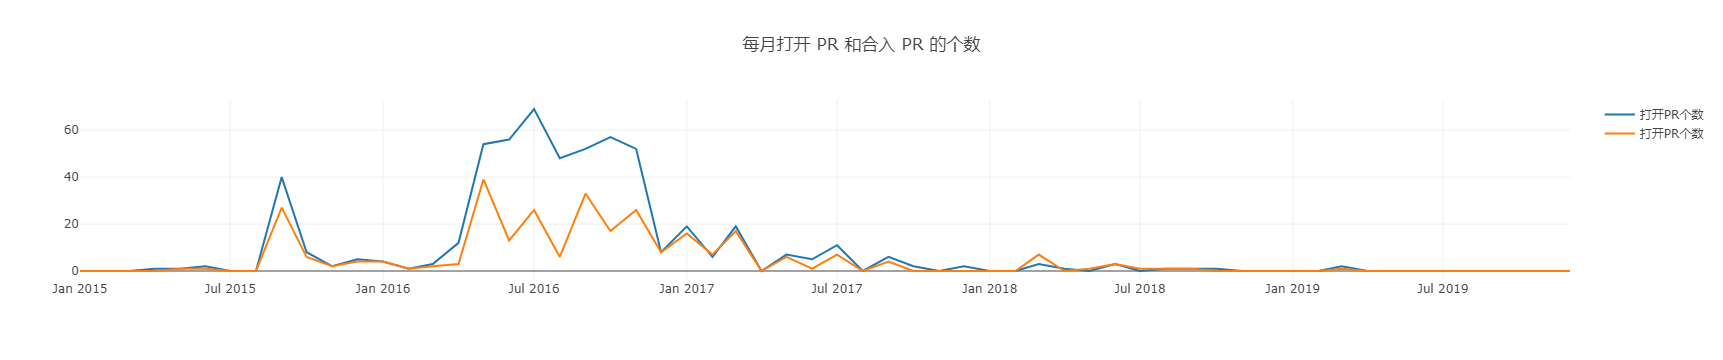

┌─────────┬───────────┬────────────┐
│ (index) │   日期    │ 打开PR个数 │
├─────────┼───────────┼────────────┤
│    0    │ '2015-1'  │    '0'     │
│    1    │ '2015-2'  │    '0'     │
│    2    │ '2015-3'  │    '0'     │
│    3    │ '2015-4'  │    '0'     │
│    4    │ '2015-5'  │    '1'     │
│    5    │ '2015-6'  │    '1'     │
│    6    │ '2015-7'  │    '0'     │
│    7    │ '2015-8'  │    '0'     │
│    8    │ '2015-9'  │    '27'    │
│    9    │ '2015-10' │    '6'     │
│   10    │ '2015-11' │    '2'     │
│   11    │ '2015-12' │    '4'     │
│   12    │ '2016-1'  │    '4'     │
│   13    │ '2016-2'  │    '1'     │
│   14    │ '2016-3'  │    '2'     │
│   15    │ '2016-4'  │    '3'     │
│   16    │ '2016-5'  │    '39'    │
│   17    │ '2016-6'  │    '13'    │
│   18    │ '2016-7'  │    '26'    │
│   19    │ '2016-8'  │    '6'     │
│   20    │ '2016-9'  │    '33'    │
│   21    │ '2016-10' │    '17'    │
│   22    │ '2016-11' │    '26'    │
│   23    │ '2016-12' │    '8'     │
│   24 

In [7]:
Promise.all(yms.map(ym => {
    var q = `
            SELECT count(CASE WHEN repo_id='32665718' AND type='PullRequestEvent' AND action='opened' AND toMonth(created_at)=${ym['m']} THEN 1 ELSE NULL END) AS open,
            count(CASE WHEN repo_id='32665718' AND type='PullRequestEvent' AND pull_merged=1 AND toMonth(created_at)=${ym['m']} THEN 1 ELSE NULL END) AS merge
            FROM github_log.year${ym['y']}
            `
    return query(q);
})).then(data => {
    var openCount = [], tableDict = [], mergeCount = [];
    data.forEach((d, i) => {
        openCount.push(d[0].open);
        mergeCount.push(d[0].merge);
        tableDict.push({'ym': yms_axis[i], 'open': openCount[openCount.length-1], 'merge': mergeCount[mergeCount.length-1]});
    });
    openDigger.render.plotly([
        {x: yms_axis, y: openCount, mode: 'scatter', name: '打开PR个数'},
        {x: yms_axis, y: mergeCount, mode: 'scatter', name: '打开PR个数'},
    ], {
        title: '每月打开 PR 和合入 PR 的个数',
    });
    console.table(tableDict.map((d) => {
        return {
            '日期': d.ym,
            '打开PR个数': d.open,
            '打开PR个数': d.merge,
        };
    }));
})

### 4. 每月在仓库中活跃（只要有日志产生就算）的不同开发者总数

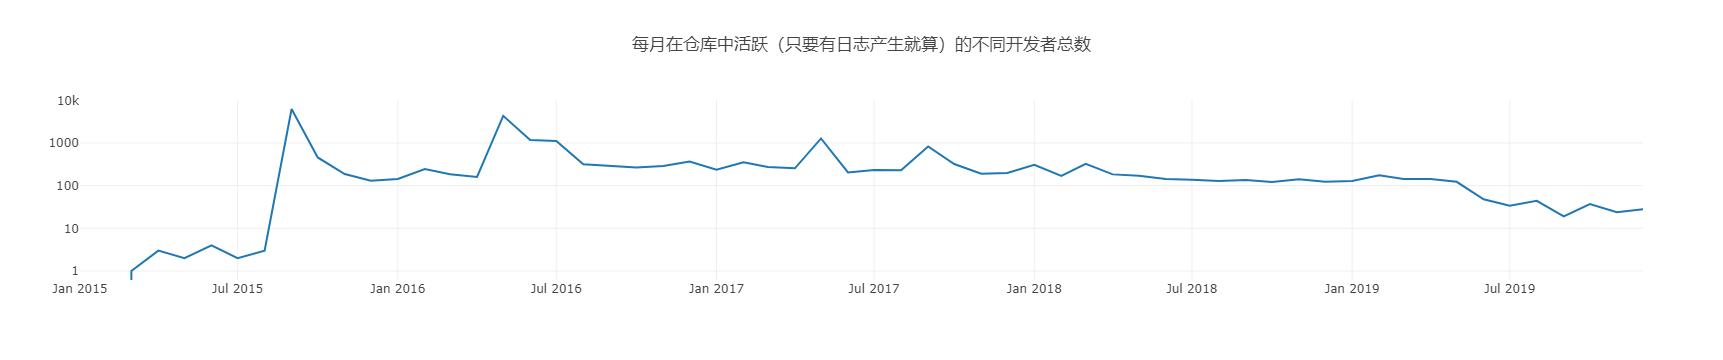

┌─────────┬───────────┬────────────┐
│ (index) │   日期    │ 开发者总数 │
├─────────┼───────────┼────────────┤
│    0    │ '2015-1'  │    '0'     │
│    1    │ '2015-2'  │    '0'     │
│    2    │ '2015-3'  │    '1'     │
│    3    │ '2015-4'  │    '3'     │
│    4    │ '2015-5'  │    '2'     │
│    5    │ '2015-6'  │    '4'     │
│    6    │ '2015-7'  │    '2'     │
│    7    │ '2015-8'  │    '3'     │
│    8    │ '2015-9'  │   '6269'   │
│    9    │ '2015-10' │   '459'    │
│   10    │ '2015-11' │   '187'    │
│   11    │ '2015-12' │   '130'    │
│   12    │ '2016-1'  │   '143'    │
│   13    │ '2016-2'  │   '246'    │
│   14    │ '2016-3'  │   '185'    │
│   15    │ '2016-4'  │   '160'    │
│   16    │ '2016-5'  │   '4334'   │
│   17    │ '2016-6'  │   '1170'   │
│   18    │ '2016-7'  │   '1110'   │
│   19    │ '2016-8'  │   '316'    │
│   20    │ '2016-9'  │   '291'    │
│   21    │ '2016-10' │   '267'    │
│   22    │ '2016-11' │   '288'    │
│   23    │ '2016-12' │   '368'    │
│   24  

In [10]:
Promise.all(yms.map(ym => {
    var q = `
            SELECT COUNT(DISTINCT actor_id) as user
            FROM github_log.year${ym['y']}
            WHERE repo_id='32665718' AND toMonth(created_at)=${ym['m']}
            `
    return query(q);
})).then(data => {
    var userCount = [], tableDict = [];
    data.forEach((d, i) => {
        userCount.push(d[0].user);
        tableDict.push({'ym': yms_axis[i], 'user': userCount[userCount.length-1]});
    });
    openDigger.render.plotly([
        {x: yms_axis, y: userCount, mode: 'scatter', name: '开发者总数'},
    ], {
        title: '每月在仓库中活跃（只要有日志产生就算）的不同开发者总数',
        yaxis: {type: 'log'}
    });
    console.table(tableDict.map((d) => {
        return {
            '日期': d.ym,
            '开发者总数': d.user,
        };
    }));
})

### 5. Issue 从打开到关闭的平均时长和中位数（单位：天）

平均时长和中位数如下

In [11]:
query(
    `SELECT avg(duration) as avg, quantile(0.5)(duration) as medium FROM (
        SELECT toRelativeDayNum(issue_closed_at) - toRelativeDayNum(issue_created_at) AS duration FROM github_log.year2015 WHERE repo_id='32665718' AND type='IssuesEvent' AND duration>=0
        UNION ALL
        SELECT toRelativeDayNum(issue_closed_at) - toRelativeDayNum(issue_created_at) AS duration FROM github_log.year2016 WHERE repo_id='32665718' AND type='IssuesEvent' AND duration>=0
        UNION ALL
        SELECT toRelativeDayNum(issue_closed_at) - toRelativeDayNum(issue_created_at) AS duration FROM github_log.year2017 WHERE repo_id='32665718' AND type='IssuesEvent' AND duration>=0
        UNION ALL
        SELECT toRelativeDayNum(issue_closed_at) - toRelativeDayNum(issue_created_at) AS duration FROM github_log.year2018 WHERE repo_id='32665718' AND type='IssuesEvent' AND duration>=0
        UNION ALL
        SELECT toRelativeDayNum(issue_closed_at) - toRelativeDayNum(issue_created_at) AS duration FROM github_log.year2019 WHERE repo_id='32665718' AND type='IssuesEvent' AND duration>=0
    )`
).then(res => {console.log(res[0]);})

{ avg: 54.910714285714285, medium: 4 }


将时长进行排序，并用柱状图展示

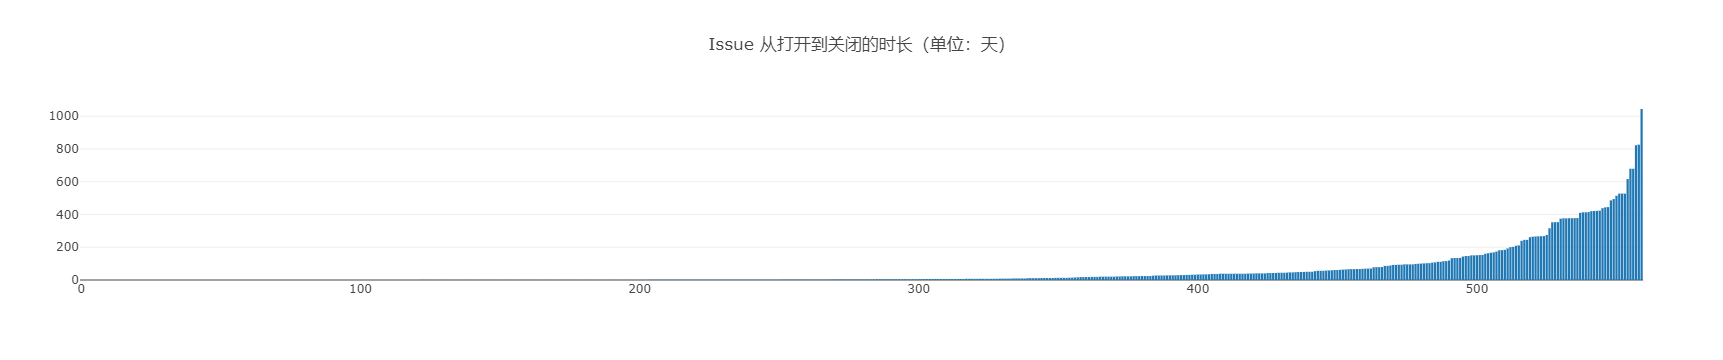

In [12]:
query(
    `SELECT duration FROM (
        SELECT toRelativeDayNum(issue_closed_at) - toRelativeDayNum(issue_created_at) AS duration FROM github_log.year2015 WHERE repo_id='32665718' AND type='IssuesEvent' AND duration>=0
        UNION ALL
        SELECT toRelativeDayNum(issue_closed_at) - toRelativeDayNum(issue_created_at) AS duration FROM github_log.year2016 WHERE repo_id='32665718' AND type='IssuesEvent' AND duration>=0
        UNION ALL
        SELECT toRelativeDayNum(issue_closed_at) - toRelativeDayNum(issue_created_at) AS duration FROM github_log.year2017 WHERE repo_id='32665718' AND type='IssuesEvent' AND duration>=0
        UNION ALL
        SELECT toRelativeDayNum(issue_closed_at) - toRelativeDayNum(issue_created_at) AS duration FROM github_log.year2018 WHERE repo_id='32665718' AND type='IssuesEvent' AND duration>=0
        UNION ALL
        SELECT toRelativeDayNum(issue_closed_at) - toRelativeDayNum(issue_created_at) AS duration FROM github_log.year2019 WHERE repo_id='32665718' AND type='IssuesEvent' AND duration>=0
    ) ORDER BY duration`
).then(data => {
    var durations = [], indices = [];
    data.forEach(d => {
        durations.push(d.duration);
    });
    indices = durations.map((_, i) => {return i;});
    openDigger.render.plotly([
        {x: indices, y: durations, type: 'bar'}
    ], {
        title: 'Issue 从打开到关闭的时长（单位：天）',
    });
})

可以发现时长特别长的Issue集中在后半部分，从而导致最终的中位数和平均数相差很大。

### 6. PR 从打开到合入的平均时长和中位数（单位：天）

平均时长和中位数如下

In [13]:
query(
    `SELECT avg(duration) as avg, quantile(0.5)(duration) as medium FROM (
        SELECT intDiv(minus(max(created_at), min(created_at))/3600, 24) AS duration FROM (
            SELECT issue_id, action, created_at FROM github_log.year2015 WHERE repo_id='32665718' AND type='PullRequestEvent'
            UNION ALL
            SELECT issue_id, action, created_at FROM github_log.year2016 WHERE repo_id='32665718' AND type='PullRequestEvent'
            UNION ALL
            SELECT issue_id, action, created_at FROM github_log.year2017 WHERE repo_id='32665718' AND type='PullRequestEvent'
            UNION ALL
            SELECT issue_id, action, created_at FROM github_log.year2018 WHERE repo_id='32665718' AND type='PullRequestEvent'
            UNION ALL
            SELECT issue_id, action, created_at FROM github_log.year2019 WHERE repo_id='32665718' AND type='PullRequestEvent'
        ) GROUP BY issue_id
    )`
).then(res => {console.log(res[0]);})

{ avg: 7.660777385159011, medium: 1 }


将时长进行排序，并用柱状图表示

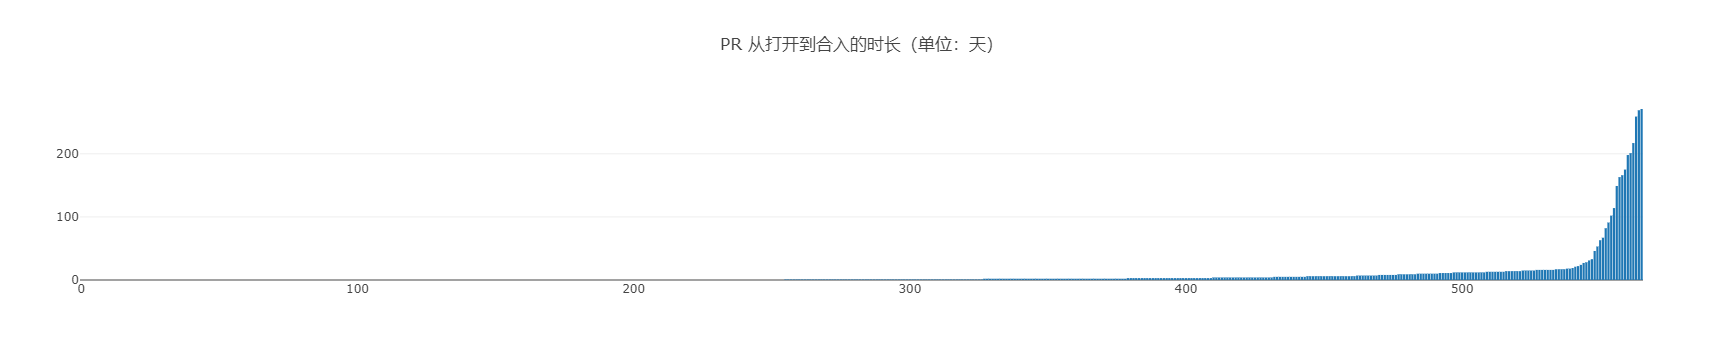

In [14]:
query(
    `SELECT duration FROM (
        SELECT intDiv(minus(max(created_at), min(created_at))/3600, 24) AS duration FROM (
            SELECT issue_id, action, created_at FROM github_log.year2015 WHERE repo_id='32665718' AND type='PullRequestEvent'
            UNION ALL
            SELECT issue_id, action, created_at FROM github_log.year2016 WHERE repo_id='32665718' AND type='PullRequestEvent'
            UNION ALL
            SELECT issue_id, action, created_at FROM github_log.year2017 WHERE repo_id='32665718' AND type='PullRequestEvent'
            UNION ALL
            SELECT issue_id, action, created_at FROM github_log.year2018 WHERE repo_id='32665718' AND type='PullRequestEvent'
            UNION ALL
            SELECT issue_id, action, created_at FROM github_log.year2019 WHERE repo_id='32665718' AND type='PullRequestEvent'
        ) GROUP BY issue_id
    ) ORDER BY duration`
).then(data => {
    var durations = [], indices = [];
    data.forEach(d => {
        durations.push(d.duration);
    });
    indices = durations.map((_, i) => {return i;});
    openDigger.render.plotly([
        {x: indices, y: durations, type: 'bar'}
    ], {
        title: 'PR 从打开到合入的时长（单位：天）',
    });
})

### 7. Issue和PR从打开到第一次有人回复（非本人回复）的平均时长和中位数（单位：天）

平均时长和中位数如下

In [15]:
query(
    `SELECT avg(duration) as avg, quantile(0.5)(duration) as medium FROM (
        SELECT minus(toRelativeDayNum(min(issue_comment_created_at)), toRelativeDayNum(min(issue_created_at))) AS duration  FROM (
            SELECT issue_id, issue_created_at, issue_comment_created_at FROM github_log.year2015 WHERE repo_id='32665718' AND issue_id<>0 AND issue_comment_author_id<>0 AND issue_comment_author_id<>issue_author_id
            UNION ALL
            SELECT issue_id, issue_created_at, issue_comment_created_at FROM github_log.year2016 WHERE repo_id='32665718' AND issue_id<>0 AND issue_comment_author_id<>0 AND issue_comment_author_id<>issue_author_id
            UNION ALL
            SELECT issue_id, issue_created_at, issue_comment_created_at FROM github_log.year2017 WHERE repo_id='32665718' AND issue_id<>0 AND issue_comment_author_id<>0 AND issue_comment_author_id<>issue_author_id
            UNION ALL
            SELECT issue_id, issue_created_at, issue_comment_created_at FROM github_log.year2018 WHERE repo_id='32665718' AND issue_id<>0 AND issue_comment_author_id<>0 AND issue_comment_author_id<>issue_author_id
            UNION ALL
            SELECT issue_id, issue_created_at, issue_comment_created_at FROM github_log.year2019 WHERE repo_id='32665718' AND issue_id<>0 AND issue_comment_author_id<>0 AND issue_comment_author_id<>issue_author_id
        ) GROUP BY issue_id
    )`
).then(res => {console.log(res[0]);})

{ avg: 18.841930116472547, medium: 1 }


将时长进行排序，并用柱状图表示

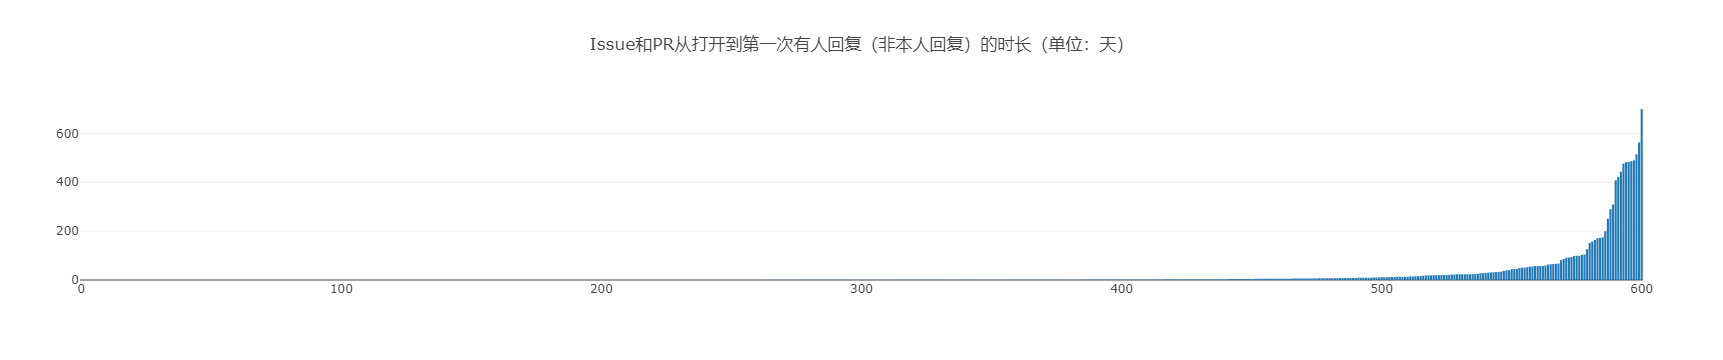

In [16]:
query(
    `SELECT duration FROM (
        SELECT minus(toRelativeDayNum(min(issue_comment_created_at)), toRelativeDayNum(min(issue_created_at))) AS duration  FROM (
            SELECT issue_id, issue_created_at, issue_comment_created_at FROM github_log.year2015 WHERE repo_id='32665718' AND issue_id<>0 AND issue_comment_author_id<>0 AND issue_comment_author_id<>issue_author_id
            UNION ALL
            SELECT issue_id, issue_created_at, issue_comment_created_at FROM github_log.year2016 WHERE repo_id='32665718' AND issue_id<>0 AND issue_comment_author_id<>0 AND issue_comment_author_id<>issue_author_id
            UNION ALL
            SELECT issue_id, issue_created_at, issue_comment_created_at FROM github_log.year2017 WHERE repo_id='32665718' AND issue_id<>0 AND issue_comment_author_id<>0 AND issue_comment_author_id<>issue_author_id
            UNION ALL
            SELECT issue_id, issue_created_at, issue_comment_created_at FROM github_log.year2018 WHERE repo_id='32665718' AND issue_id<>0 AND issue_comment_author_id<>0 AND issue_comment_author_id<>issue_author_id
            UNION ALL
            SELECT issue_id, issue_created_at, issue_comment_created_at FROM github_log.year2019 WHERE repo_id='32665718' AND issue_id<>0 AND issue_comment_author_id<>0 AND issue_comment_author_id<>issue_author_id
        ) GROUP BY issue_id
    ) ORDER BY duration`
).then(data => {
    var durations = [], indices = [];
    data.forEach(d => {
        durations.push(d.duration);
    });
    indices = durations.map((_, i) => {return i;});
    openDigger.render.plotly([
        {x: indices, y: durations, type: 'bar'}
    ], {
        title: 'Issue和PR从打开到第一次有人回复（非本人回复）的时长（单位：天）',
    });
})

### 8. 根据你观察到的仓库的历史数据，尝试找到几个你认为关键或值得注意的时间节点

- 15、16年项目蓬勃发展，月均star稳定在200及以上，尤其在15年9月与16年5月达到月均5000左右star 
- 自17年9月作者vlad-shatskyi离开项目，靠同事维护，开始走低（稳定在月均100-200star）
- 19年5月项目archive，star数骤降，稳定在月均10-20star